# Assignment 3 -- Warm-Up

*This notebook is an adaptation of for CLIP ([openai's github/colab material](https://colab.research.google.com/github/openai/CLIP/blob/main/notebooks/)) and the colab material from the Stanford 2022 course cs231n by Fei-Fei Li (github material).*

---



## Introduction
Documentation and code of CLIP: https://github.com/openai/CLIP

In this notebook, you will be working with CLIP (Contrastive Language-Image Pre-Training) model. We will be using the implementation and the pre-trained model based on ViT. This is a visual transformer, see the paper for details, or the (upcoming) course slides on ILIAS.

In [1]:
import os
import sys

import numpy as np
import torch
print("Torch version:", torch.__version__)

try:
    import pandas
except ModuleNotFoundError:
    !conda install pandas

Torch version: 2.0.1


In [2]:
#conda update -n base -c defaults conda
#conda install torchvision -c pytorch

# Setup: Preparation for Colab
***If you work on your own local environment, you can skip this part and go directly to the Warm-Up.***

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
!pip install cython

In [ ]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    !pip install google-colab

In [ ]:
# Mount your Google Drive to the Colab VM:
from google.colab import drive
drive.mount('/content/drive')

# TODO: Save the unzipped assignment folder in a filder on your google Drive. 
# TODO: Enter the foldername in your Drive where you have saved it, e.g. 'assignment4/'
FOLDERNAME = None
FOLDERNAME = "MultimodalSemantics_SS2023"
assert FOLDERNAME is not None, "enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

In [ ]:
%load_ext Cython

In [ ]:
!cd /content/drive/MyDrive/$FOLDERNAME/
!ls .

# Warm-Up: Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [2]:
# Install CLIP if you don't have it yet
! pip install ftfy regex tqdm
try:
    import clip
except ModuleNotFoundError:
    ! pip install git+https://github.com/openai/CLIP.git

In [3]:
from pkg_resources import packaging

In [4]:
import torchvision
print("Torch vision version: ", torchvision.__version__)
#import torch
#torch.__version__

Torch vision version:  0.15.2


In [7]:
# If necessary:
#!conda update --yes pytorch torchvision

In [8]:
# Getting a warn(f"Failed to load image Python extension: {e}") error?
# Fix:
#!pip3 uninstall --yes torchvision
#!pip3 install torchvision==0.12.0

# Loading the model and the image preprocessor

`clip.available_models()` will list the names of available CLIP models.

In [5]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

We load the pre-trained ViT-B/32 `model` and the image preprocessor (`process`)

In [6]:
model, preprocess = clip.load("ViT-L/14")
if torch.cuda.is_available():
    model.cuda().eval()
else:
    model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


# Basics: Image Preprocessing

When feeding an image into CLIP, we first preprocess it, following a standard procedure. <br/>
The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing, namely: 
* First, normalise the pixel intensity using the dataset mean and standard deviation.
* Then, resize the input images and center-crop them to conform with the image resolution that the model expects. 

In [7]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f87b1df42c0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokeniser, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [8]:
clip.tokenize("A woman is fixing the car engine.")

tensor([[49406,   320,  2308,   533, 17423,   518,  1615,  5857,   269, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed some example images and their textual descriptions of the coda dataset (https://github.com/nala-cub/codato) to the model, and compare the similarity between the corresponding features.

The tokeniser is case-insensitive, and we can freely give any suitable textual descriptions.

***If you work on*** **google colab**, ***do the folowing to load the data:***

In [ ]:
# TODO: check that you set up your folders as described above.
image_dir = '/content/drive/MyDrive/{}/coloured_objects/'.format(FOLDERNAME)
data_dir = '/content/drive/MyDrive/{}/coloured_objects/'.format(FOLDERNAME)

***Otherwise, set your directory paths according to your local setup.***

In [9]:
# TODO: set up your paths.
FOLDERNAME = "data"
image_dir = '{}/coloured_objects/'.format(FOLDERNAME)
data_dir = '{}/coloured_objects/'.format(FOLDERNAME)

**Loading the data**

In [10]:
# We need additional packages for loading (and visualising) the images
import IPython.display
import matplotlib.pyplot as plt
from collections import OrderedDict

try:
    import skimage
except ModuleNotFoundError:
    !conda install --yes scikit-image 
    import skimage
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

*Now, we create some examples of `coloured_objects`*

In [11]:
# example images in coda (retrieved from multiPIC, inter alia) and some descriptions for them written by yourselves
descriptions = [
    ("PICTURE_69.png", "A grey-scale photo of a fruit ."),
    ("PICTURE_693.png", "A grey-scale photo of a tree ."),
    ("PICTURE_697.png", "This shows an fruit ."),
    ("PICTURE_707.png", "A grey-scale photo of a dog ."),
    ("banana_wikipedia.jpg", "This is a photo of a banana ."),
    ("PICTURE_42.png", "A photo of a pear ."),
    ("banana_gratismalvorlagen.png", "A photo of a banana ."),
    ("peach_supercoloring.png", "A grey-scale photo of a peach ."),
    # from the SWiG dataset (Pratt et al., 2019)
    ("peeling_91.jpg", "The banana is being peeled .")   
]

In [12]:
for filename in [filename for filename in os.listdir(data_dir)]:
    print(filename)

banana_gratismalvorlagen.png
banana_wikipedia.jpg
peach_supercoloring.png
peeling_91.jpg
PICTURE_42.png
PICTURE_69.png
PICTURE_693.png
PICTURE_697.png
PICTURE_707.png


***Let's visualise the image--text pairs:***

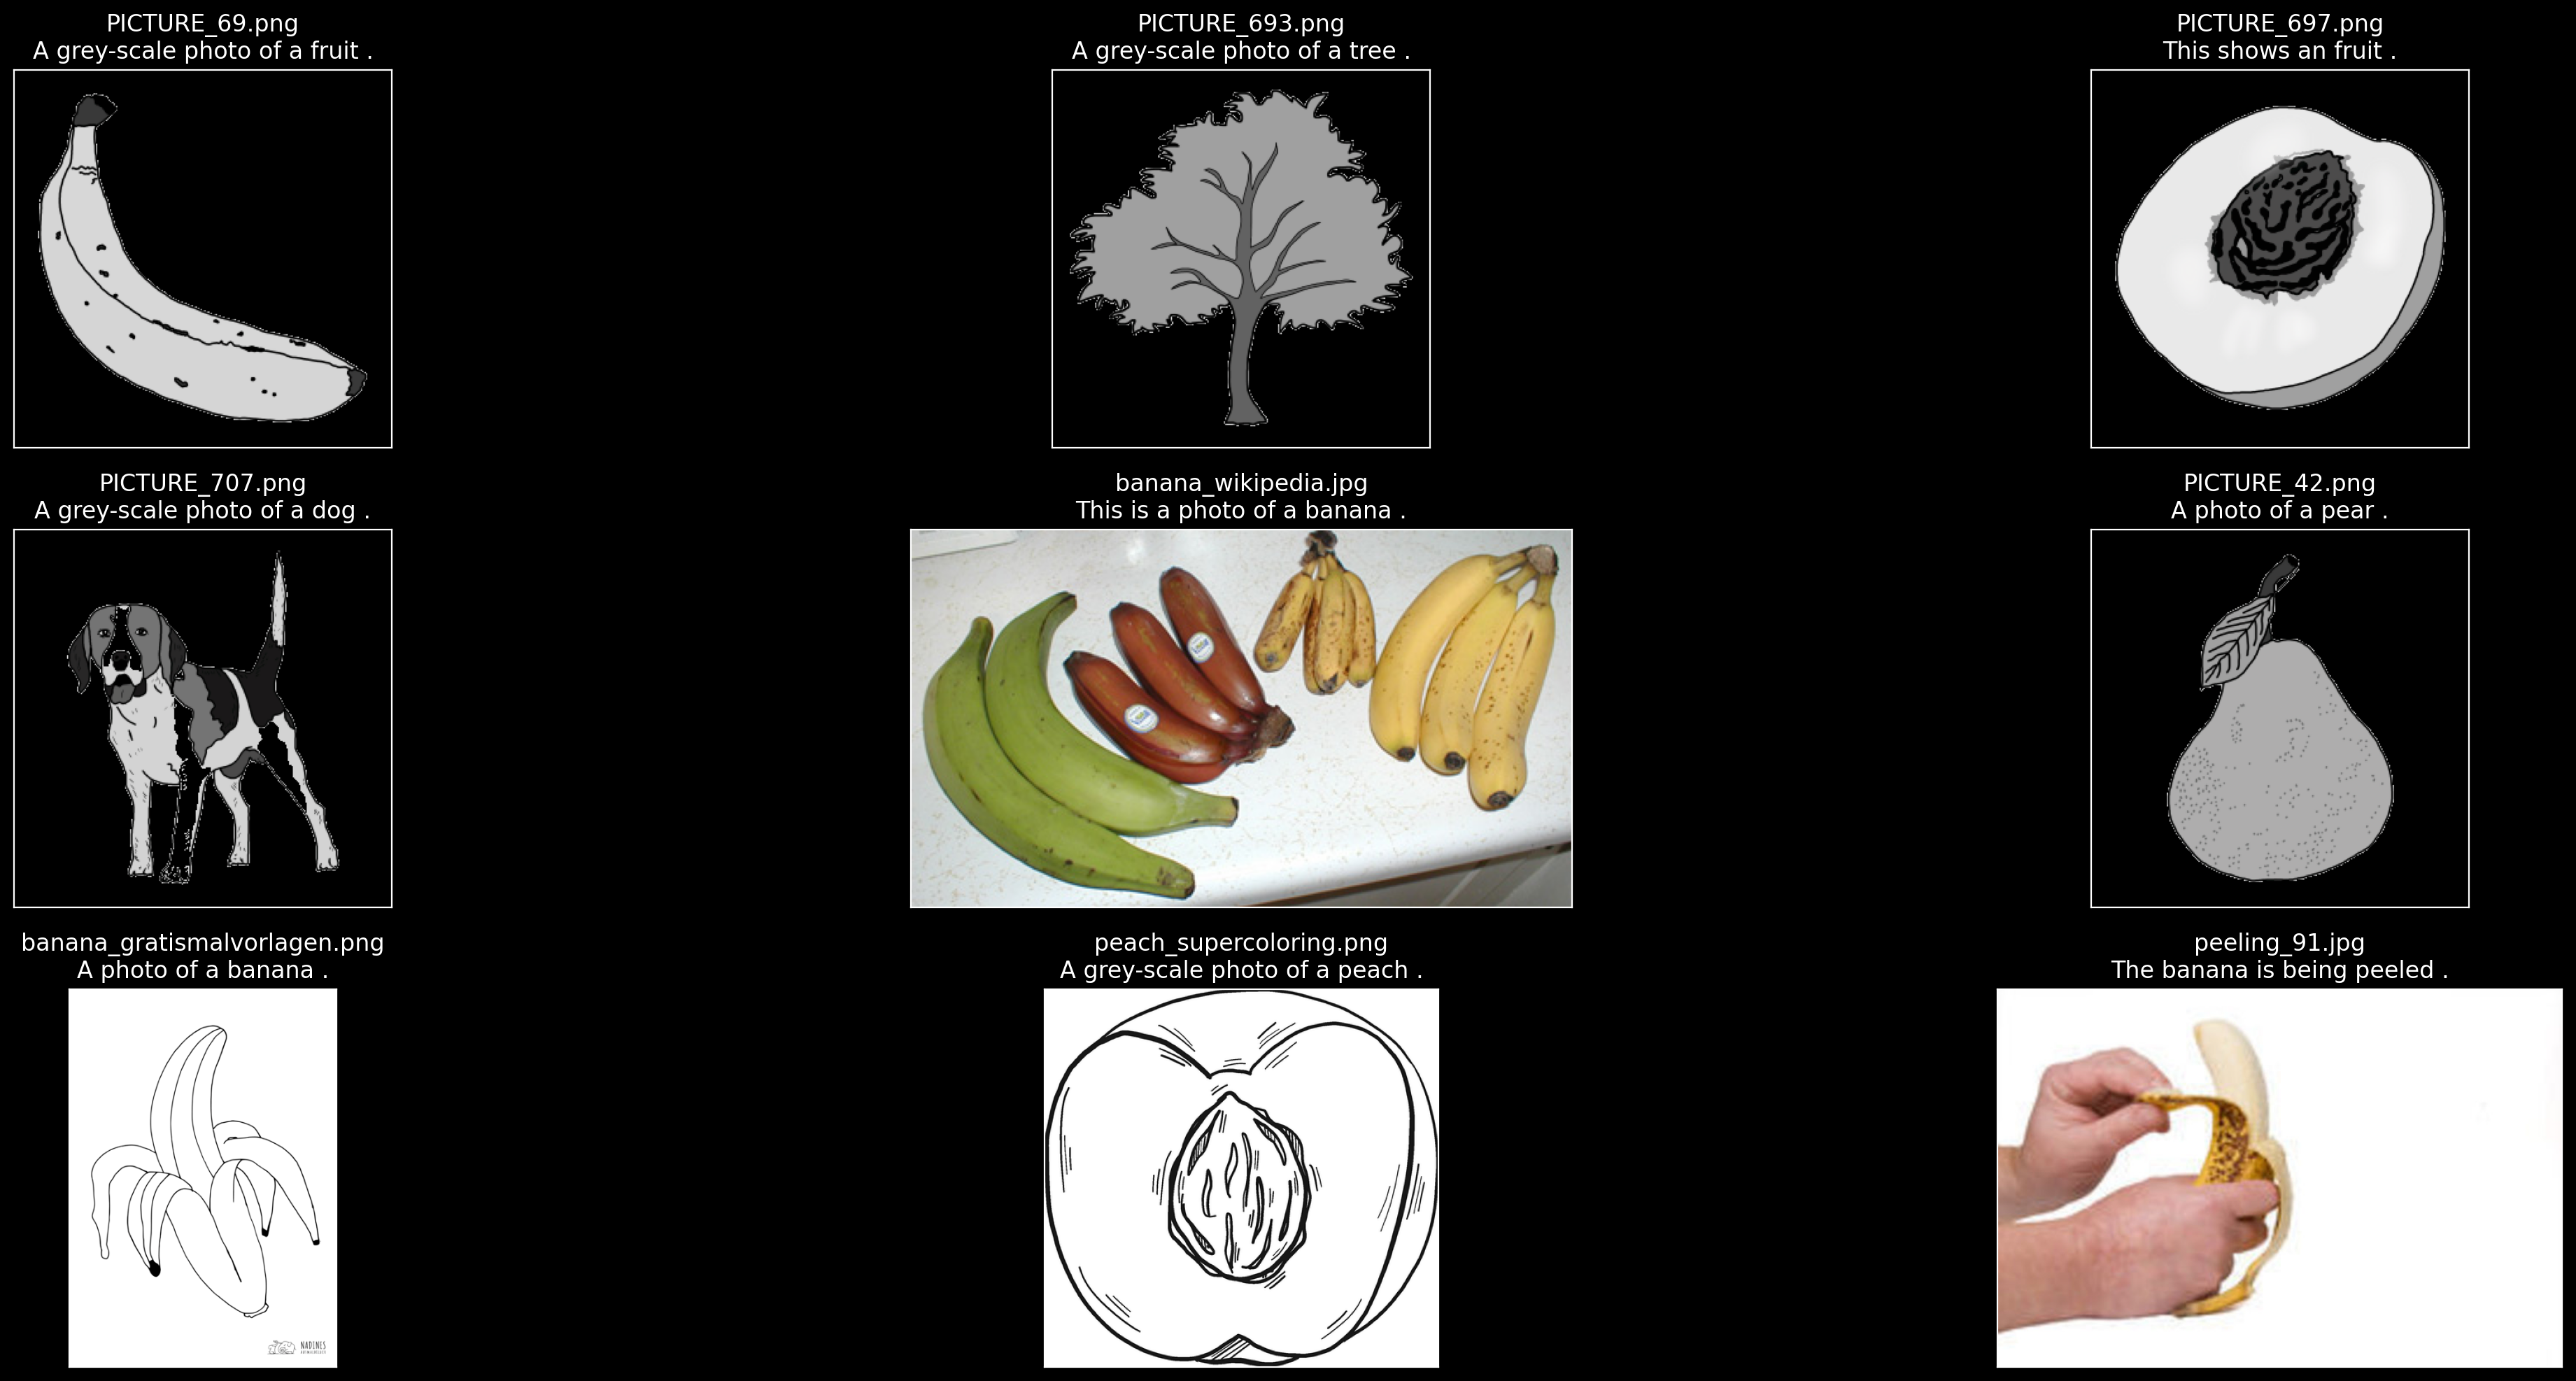

In [13]:
# plot the image-text pairs
plt.figure(figsize=(25, 10))

num_imgs = 0
for (item_id, descr) in descriptions:
    if item_id.endswith(".png") or item_id.endswith(".jpg"):
        filename = item_id
        name = os.path.splitext(filename)[0]
        image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
        plt.subplot(3, 3, num_imgs + 1)
        plt.imshow(image)
        plt.title(f"{filename}\n{descr}")
        plt.xticks([])
        plt.yticks([])

        num_imgs += 1

plt.tight_layout()

***We better load the data into some simple data structures, and then use a function for plotting them:***

In [14]:
# Load data
original_images = []
images = []
texts = []
imgnames = []

for (item_id, descr) in descriptions:
    if item_id.endswith(".png") or item_id.endswith(".jpg"):
        filename = item_id
        name = os.path.splitext(filename)[0]
        image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
        original_images.append(image)
        # We preprocess the image with CLIP's preprocessor
        images.append(preprocess(image))
        texts.append(descr)
        imgnames.append(item_id)

In [16]:
# Visualisation by iterating over the lists of images and texts
# images or original_images
def visualise(imgnm_list, img_list, text_list):
    plt.figure(figsize=(25, 10))
    num_imgs = 0
    for (item_id, image, descr) in zip(imgnm_list, img_list, text_list):
        if item_id.endswith(".png") or item_id.endswith(".jpg"):
            plt.subplot(3, 3, num_imgs + 1)
            plt.imshow(image)
            plt.title(f"{item_id}\n{descr}")
            plt.xticks([])
            plt.yticks([])

            num_imgs += 1

    plt.tight_layout()

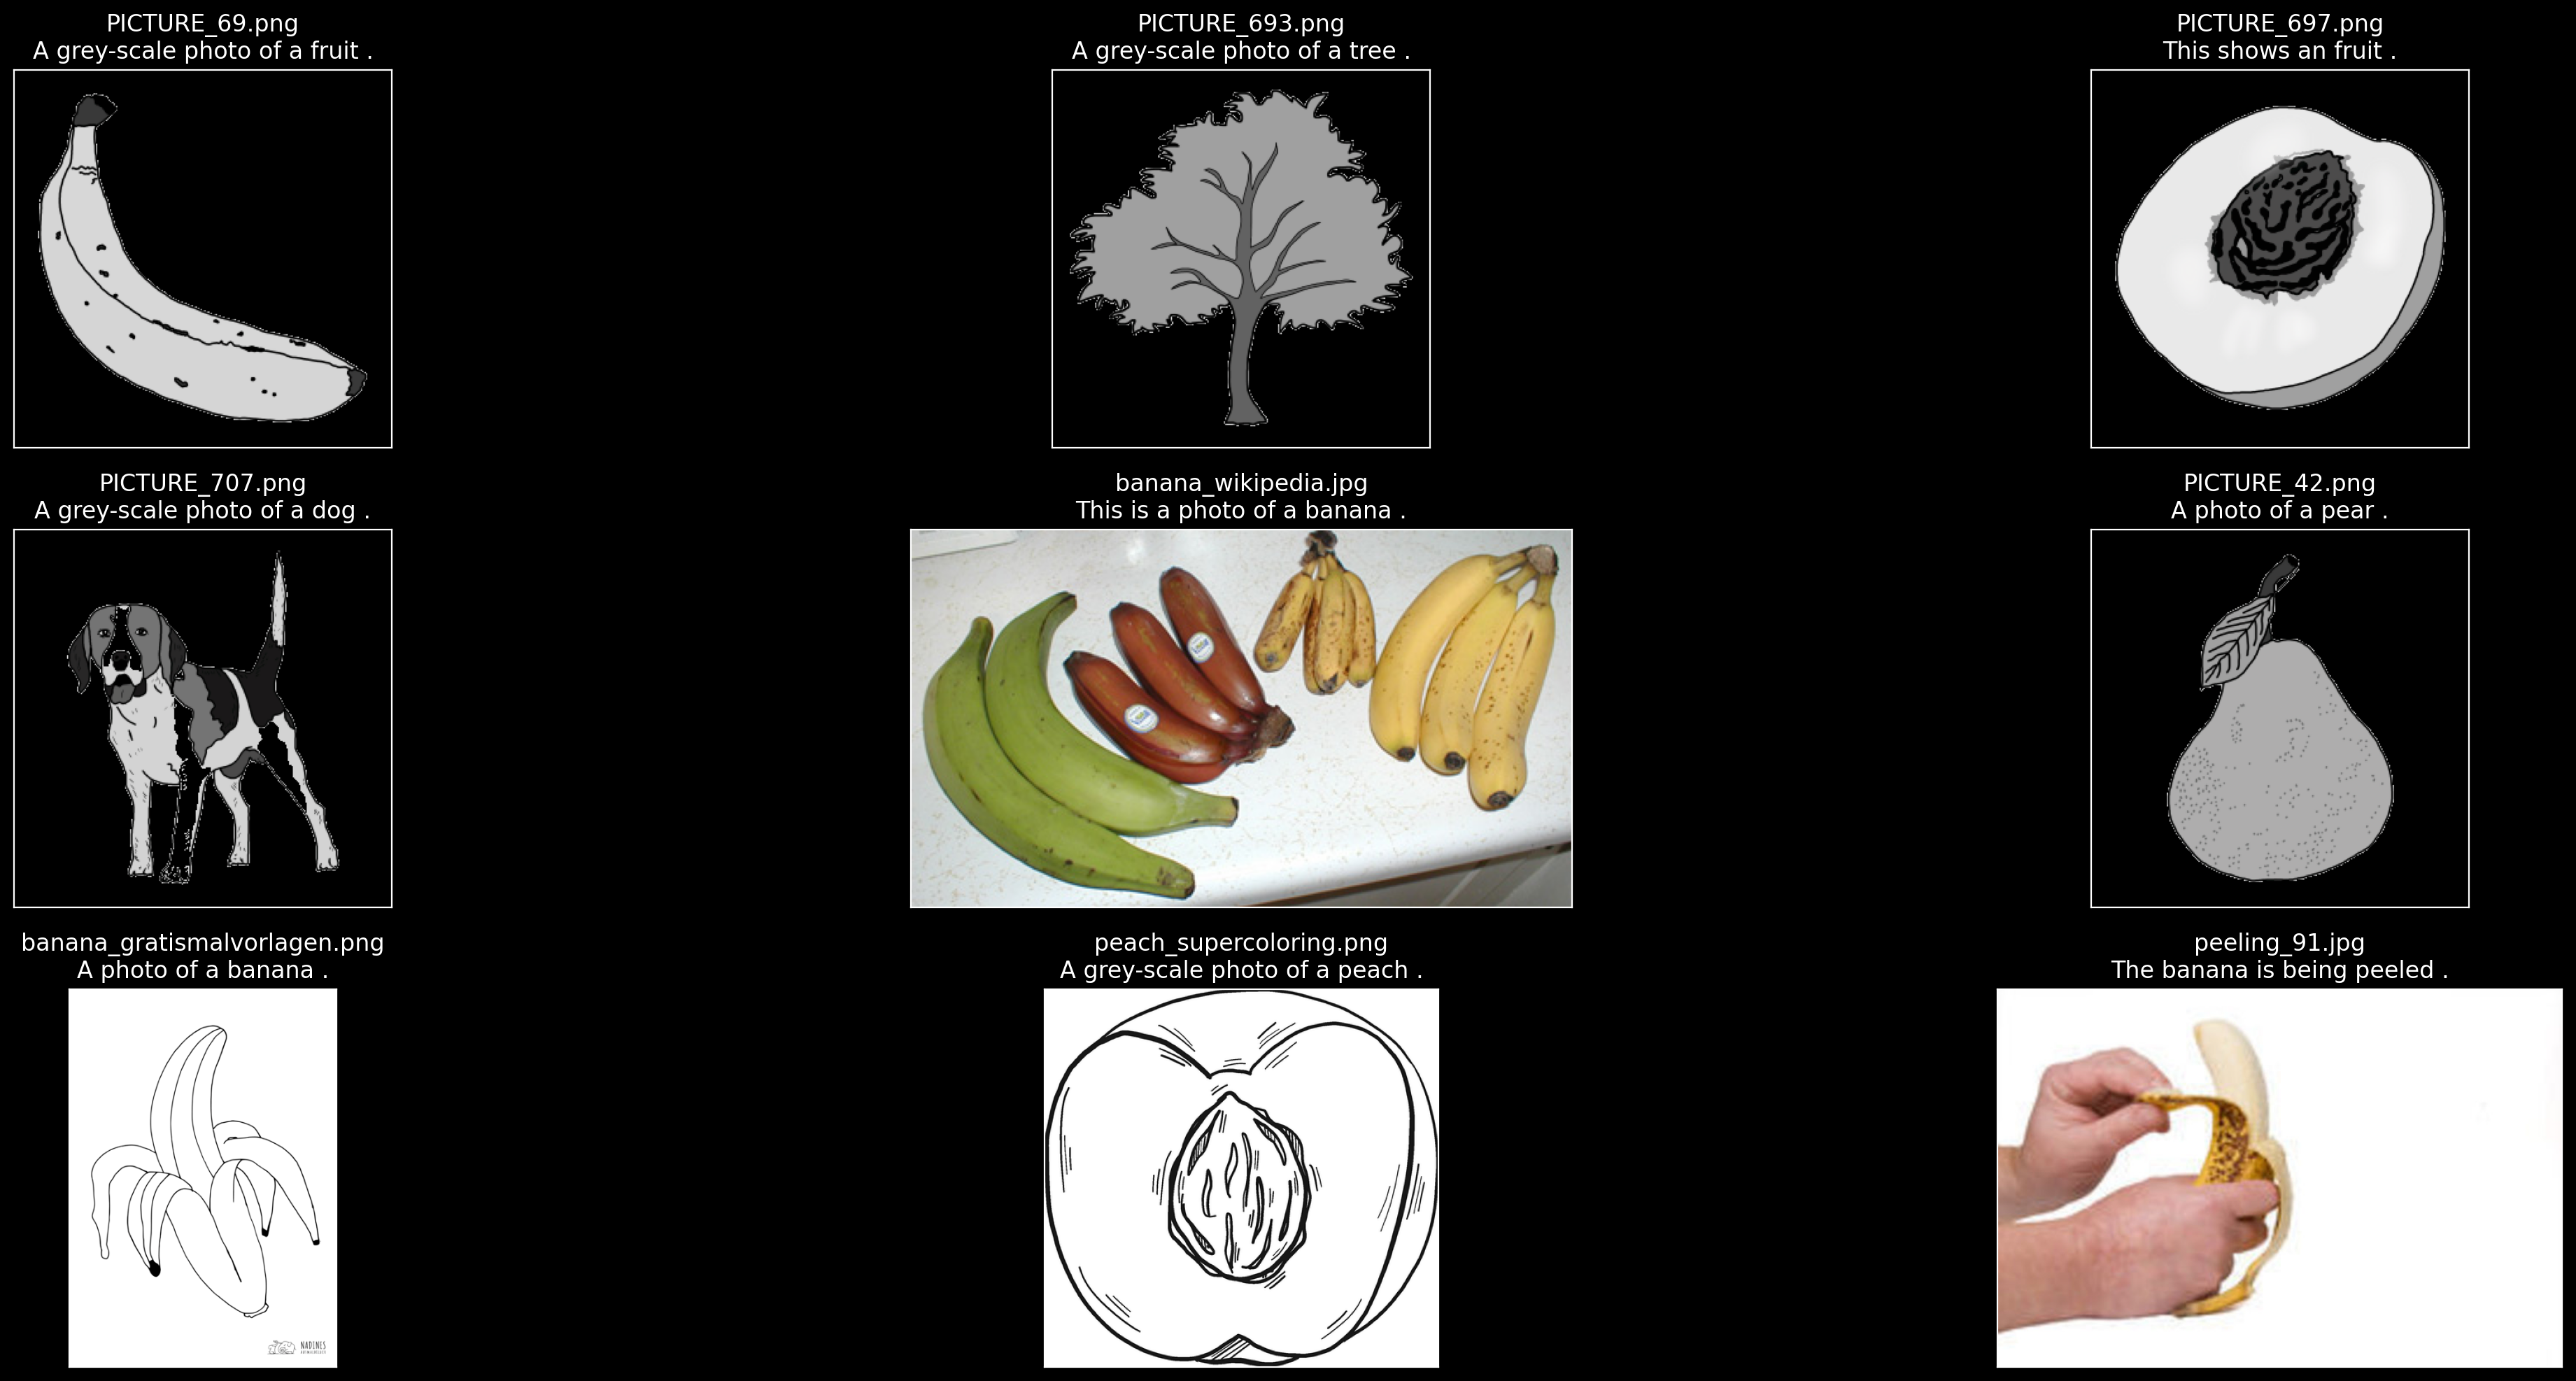

In [17]:
# imgnames, original_images, (images,) texts
visualise(imgnames, original_images, texts)

## Building features

We normalise the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

***If you work, e.g., on colab, you can use a GPU (i.e., cuda).***

In [18]:
if torch.cuda.is_available():
    image_input = torch.tensor(np.stack(images)).cuda()
    text_tokens = clip.tokenize([desc for desc in texts]).cuda()
else:
    image_input = torch.tensor(np.stack(images))#.cuda()
    text_tokens = clip.tokenize([desc for desc in texts])#.cuda()    

In [19]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Task 1: Image--Text Matching 
### In CLIP (inference time), this boils down to calculating the cosine similarity. 

We normalise the features and calculate the dot product of each pair.

In [20]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

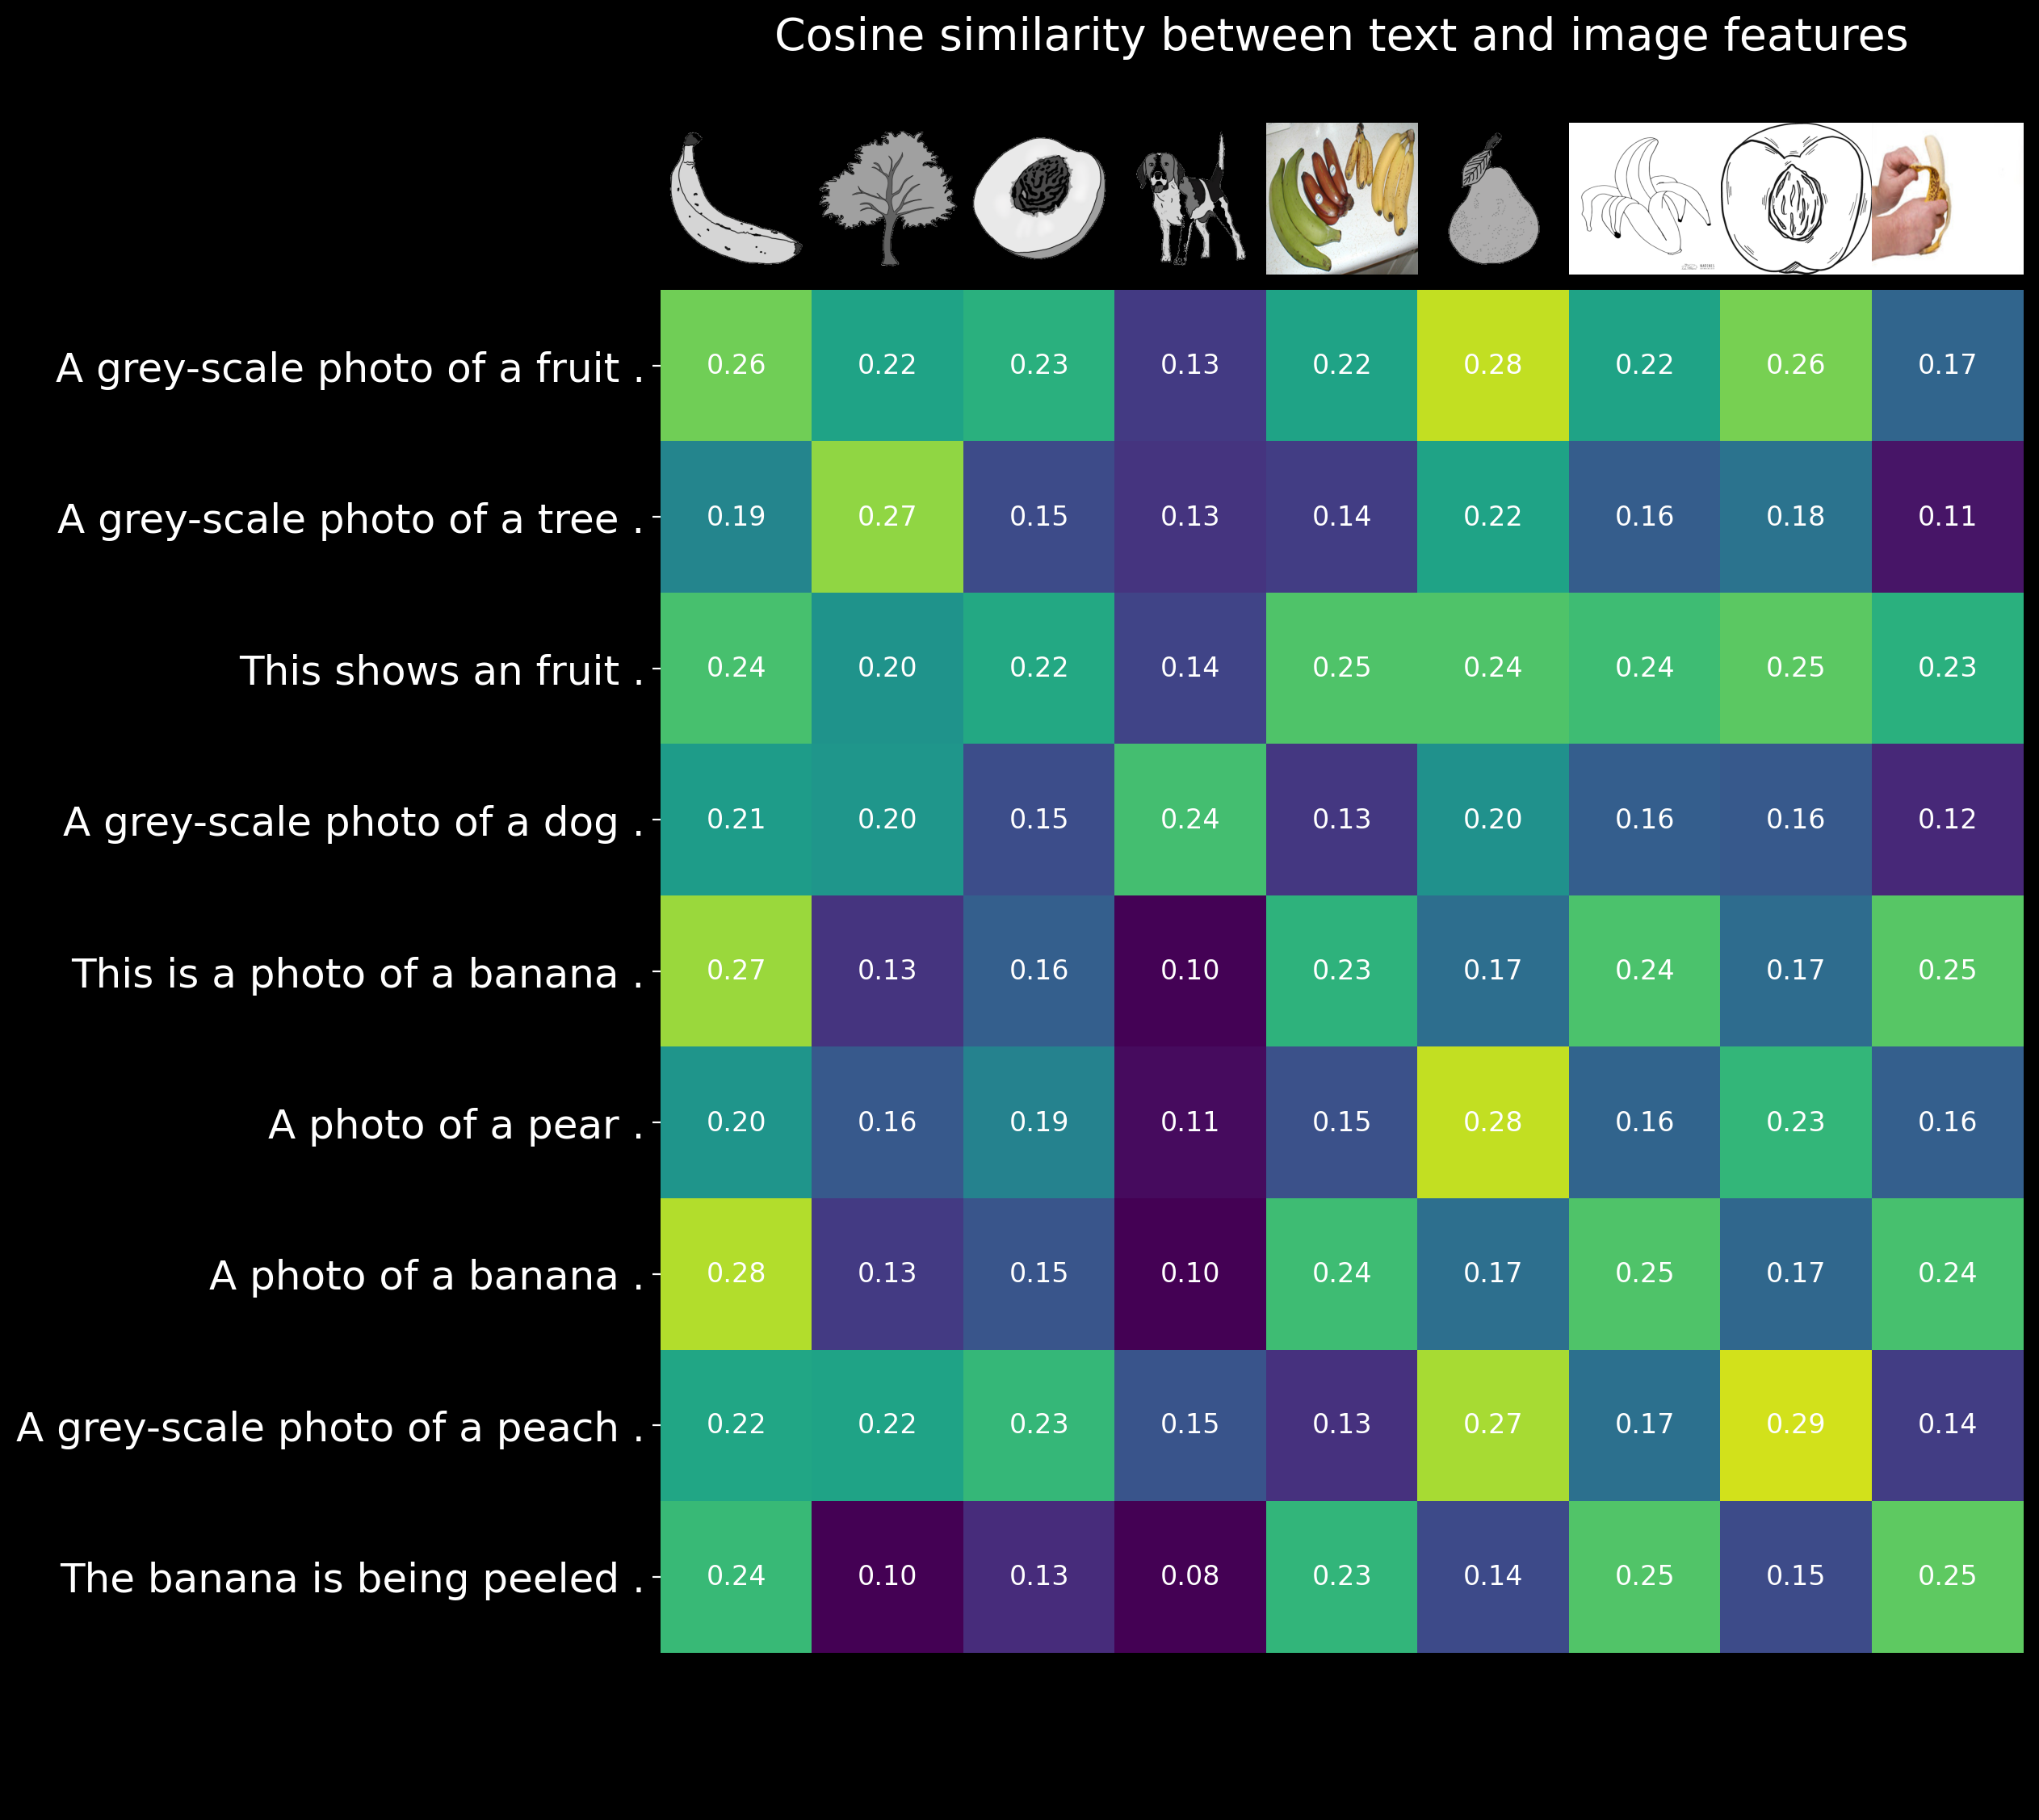

In [21]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

**TODO:** *Inspect the similarity scores between the descriptions and the images, and how the scores are (not) affected  by different verbalisations.*

---
### Interim Summary (of Image--Text Matching): Ingredients
1. Set up data, and load it into some simple data structure (see above)
2. Encode the images and texts into feature representations using CLIP
3. Compute the image--text compatibility using cosine similarity
4. (Visualise results)

**2. Feature encoding**

In [22]:
# encoding data with CLIP
if torch.cuda.is_available():
    image_input = torch.tensor(np.stack(images)).cuda()
    text_tokens = clip.tokenize(texts).cuda()
else:
    image_input = torch.tensor(np.stack(images))#.cuda()
    text_tokens = clip.tokenize(texts)#.cuda()  
# Encode the inputs
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
# And normalise the encodings
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

**3. Compute the cosine similarity**<br/>
We normalised the embeddings (above), and now compute the dot product between them.

In [23]:
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

**4. Visualise similarities**

Text(0.5, 1.0, 'Cosine similarity between text and image features')

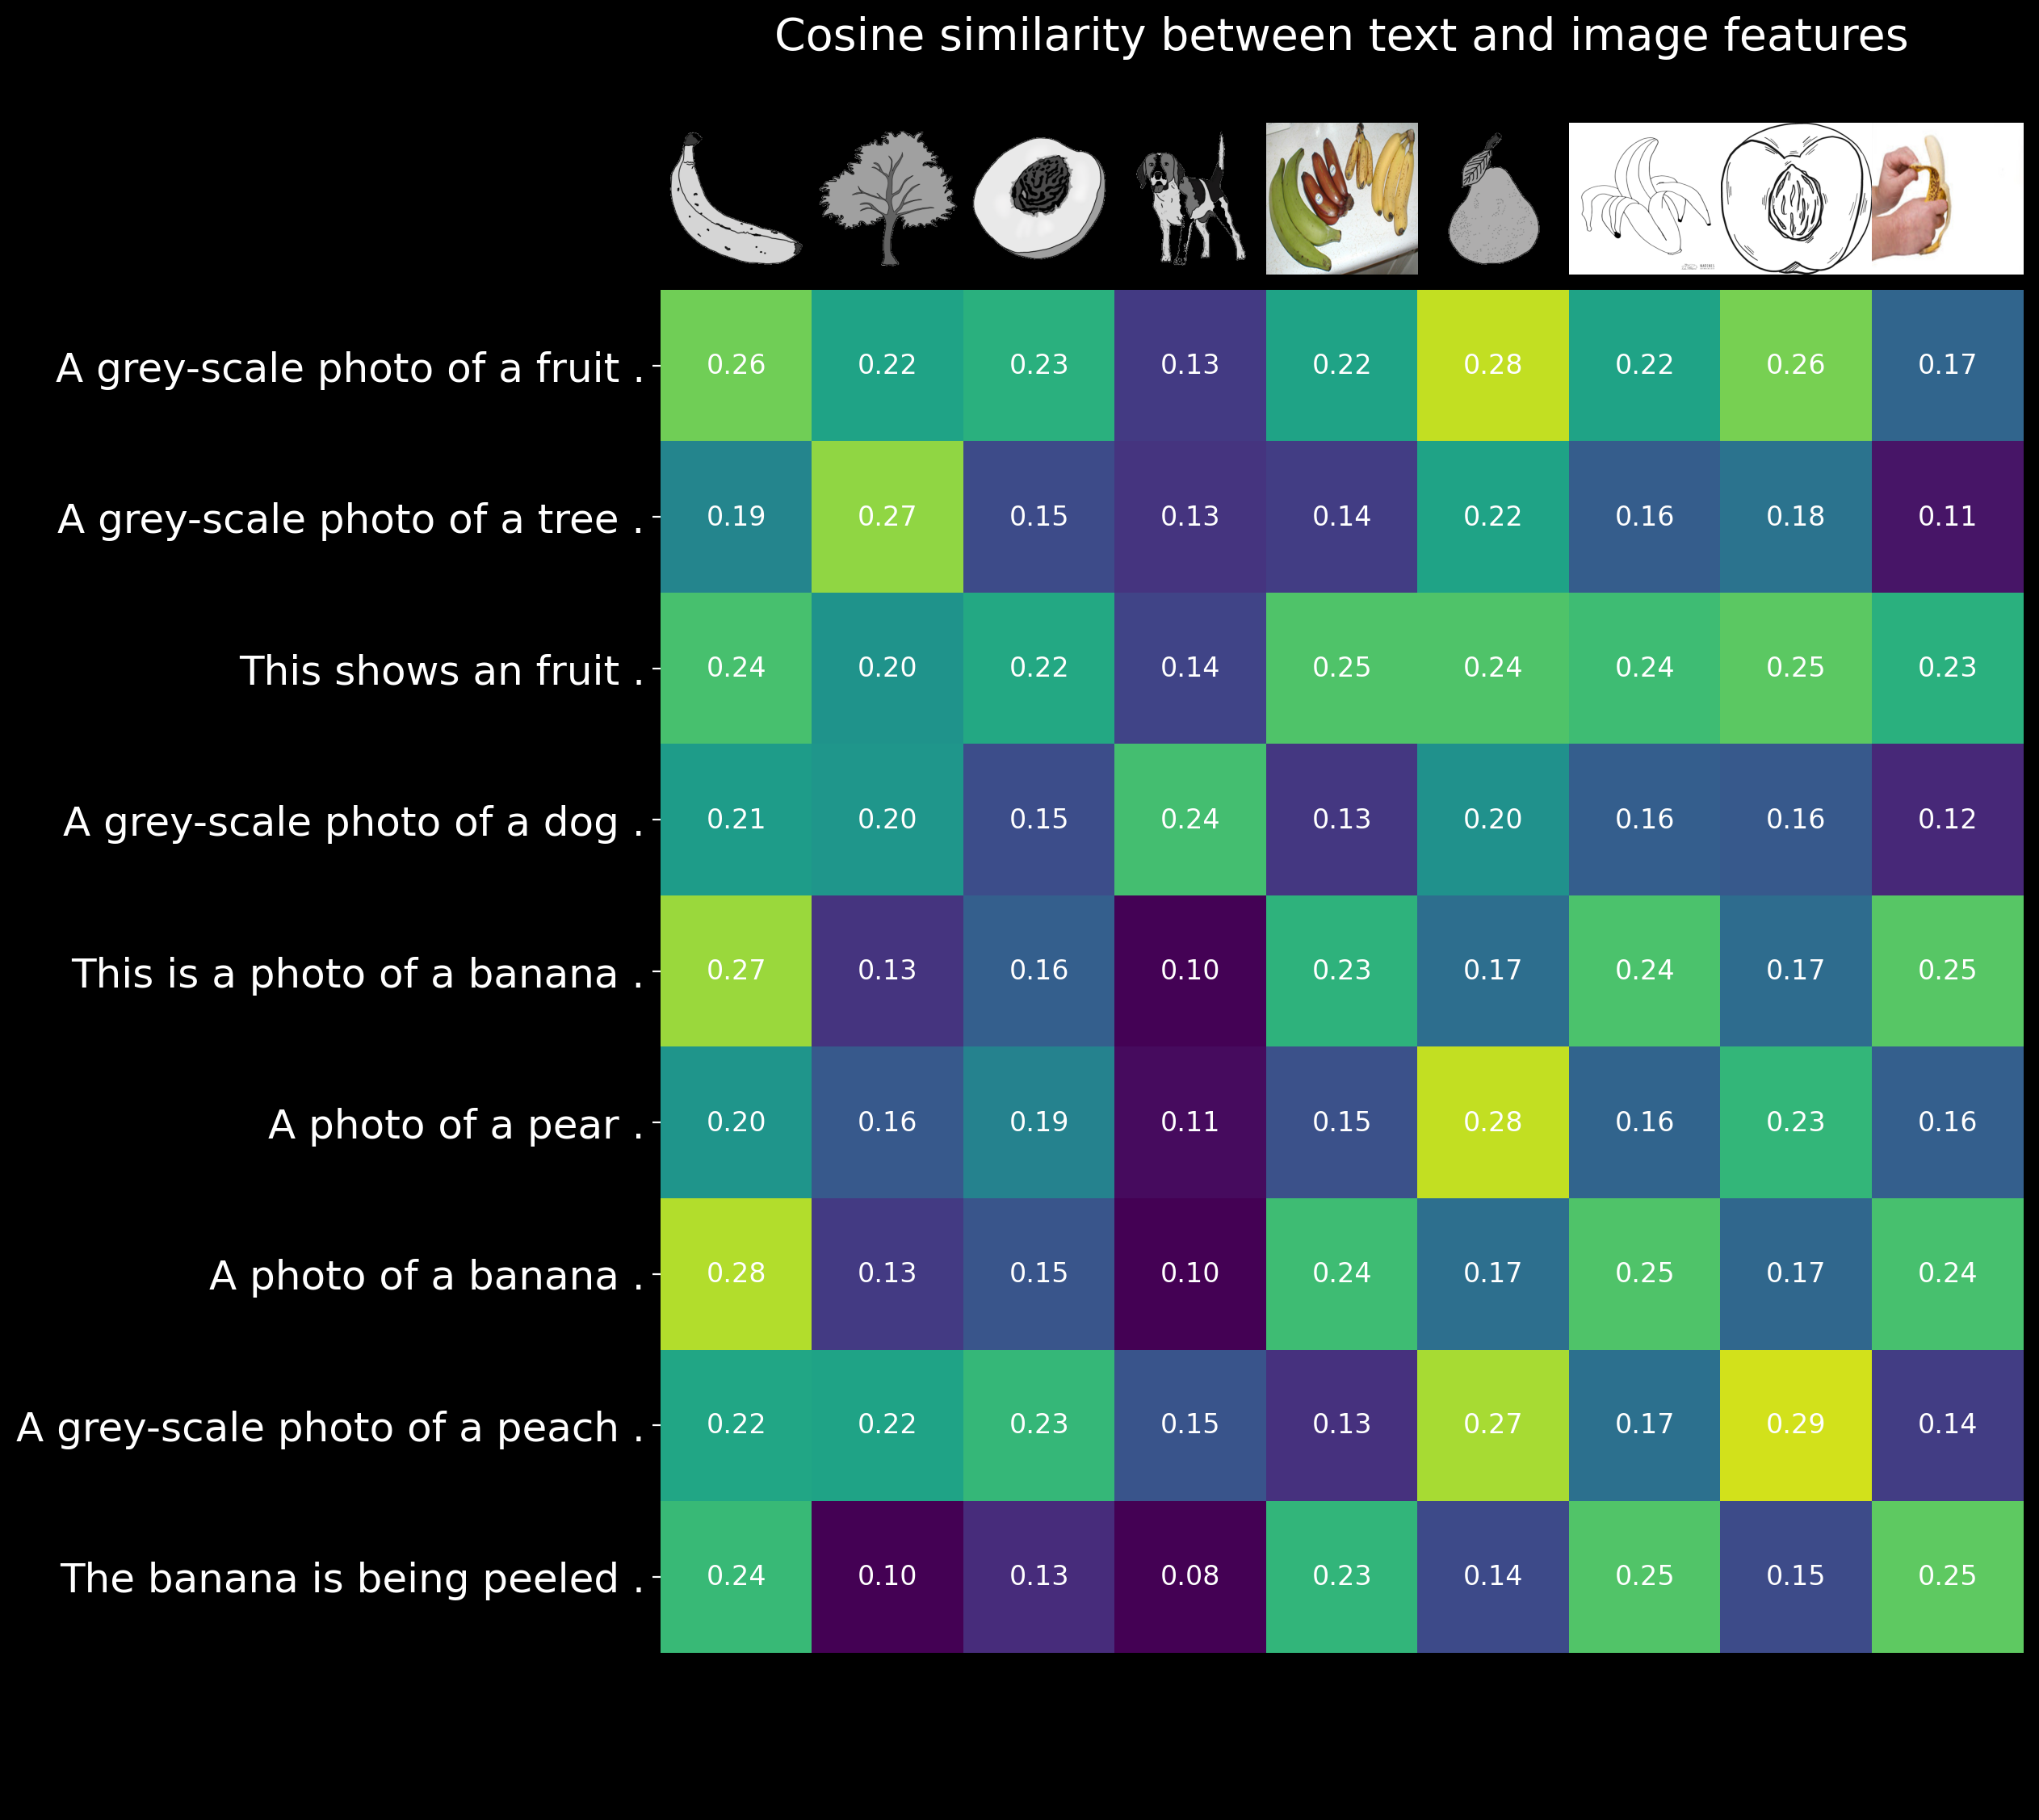

In [24]:
count = len(imgnames)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Task 2: Zero-Shot Image Classification

You can choose some vocabulary of target classes, and use them to classify your own images. 
The classification is based on the cosine similarity (times 100), specifically, on the logits to the softmax operation applied to the similarity scores. 

*Choose a target vocabulary: Let's use the 100 object classes of CIFAR100.*

In [25]:
from torchvision.datasets import CIFAR100
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [26]:
cifar100.classes[:15]

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly']

In [27]:
text_descriptions = [f"A {label} is being peeled ." for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)#.cuda()
if torch.cuda.is_available():
    text_tokens = text_tokens.cuda()

*We instantiate the template with the target classes to obtain the textual prompts:*

In [28]:
text_descriptions[:10]

['A apple is being peeled .',
 'A aquarium_fish is being peeled .',
 'A baby is being peeled .',
 'A bear is being peeled .',
 'A beaver is being peeled .',
 'A bed is being peeled .',
 'A bee is being peeled .',
 'A beetle is being peeled .',
 'A bicycle is being peeled .',
 'A bottle is being peeled .']

*Predict the classes for each test instance using zero-shot classification:*

In [29]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(4, dim=-1)

In [30]:
target_classes = cifar100.classes

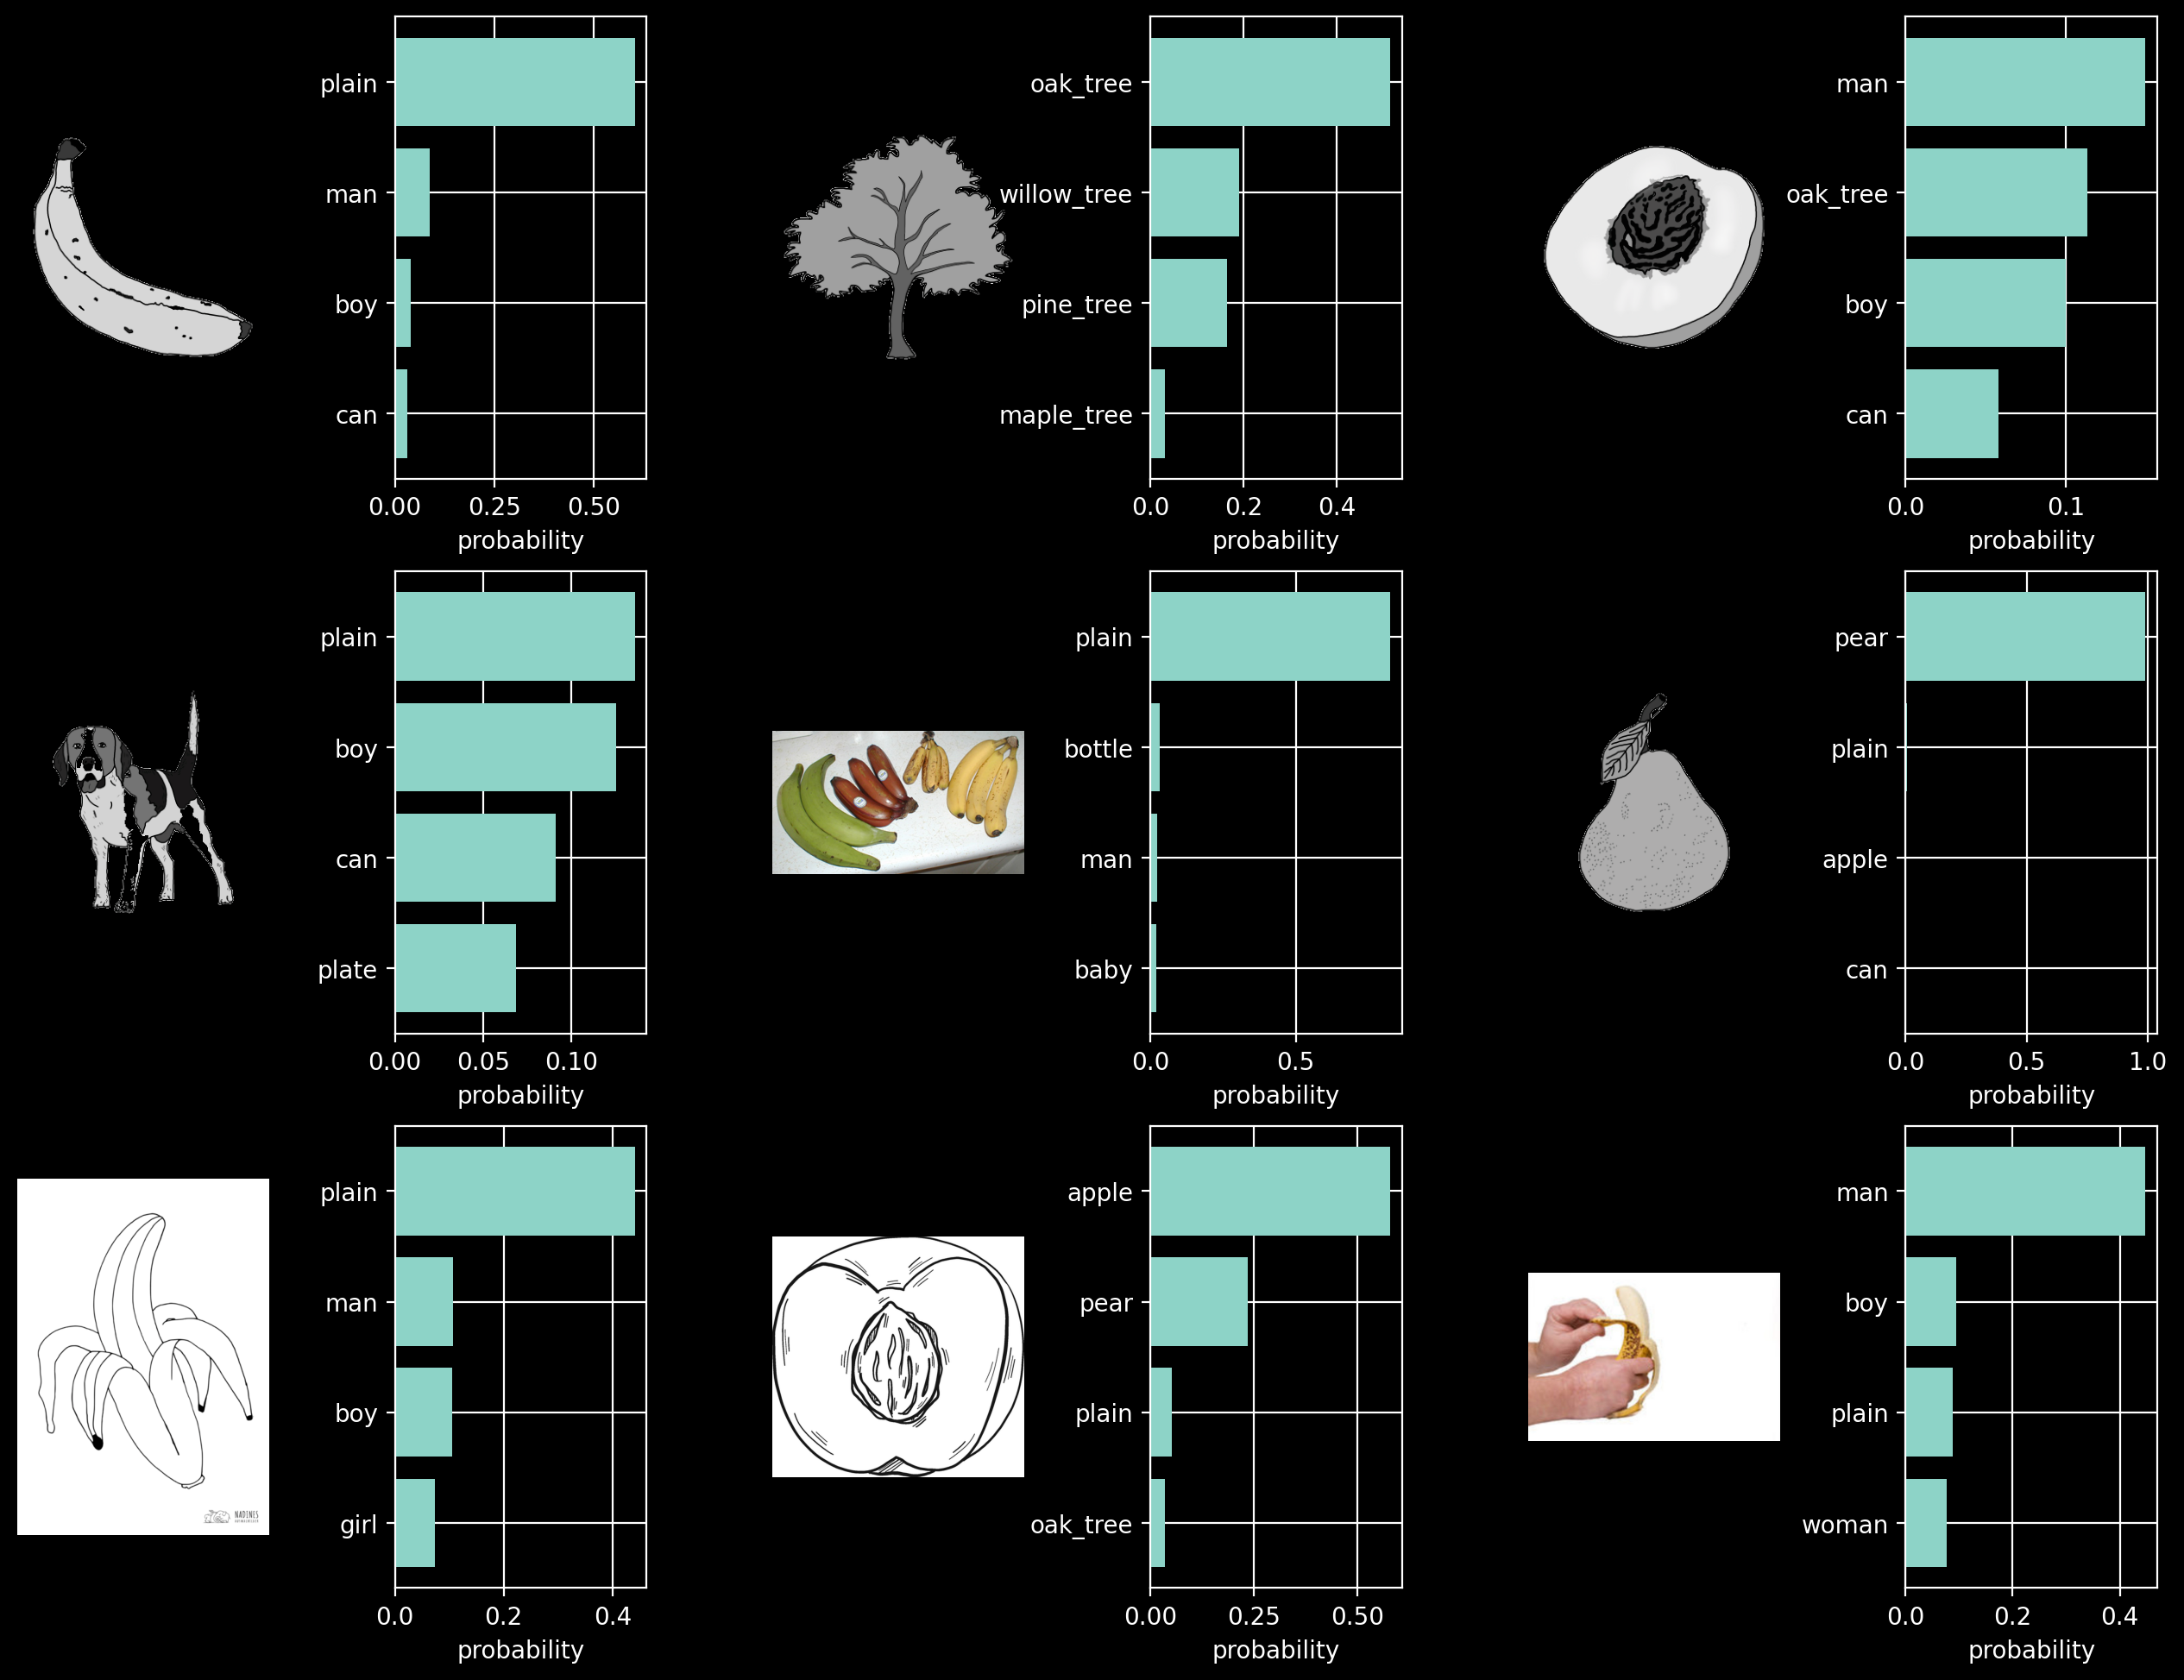

In [31]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(original_images):
    plt.subplot(4, 6, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 6, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [target_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

*Let's try another text prompt:*

In [32]:
text_descriptions = [f"A photo of a {label} ." for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)#.cuda()
if torch.cuda.is_available():
    text_tokens = text_tokens.cuda()
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(4, dim=-1)

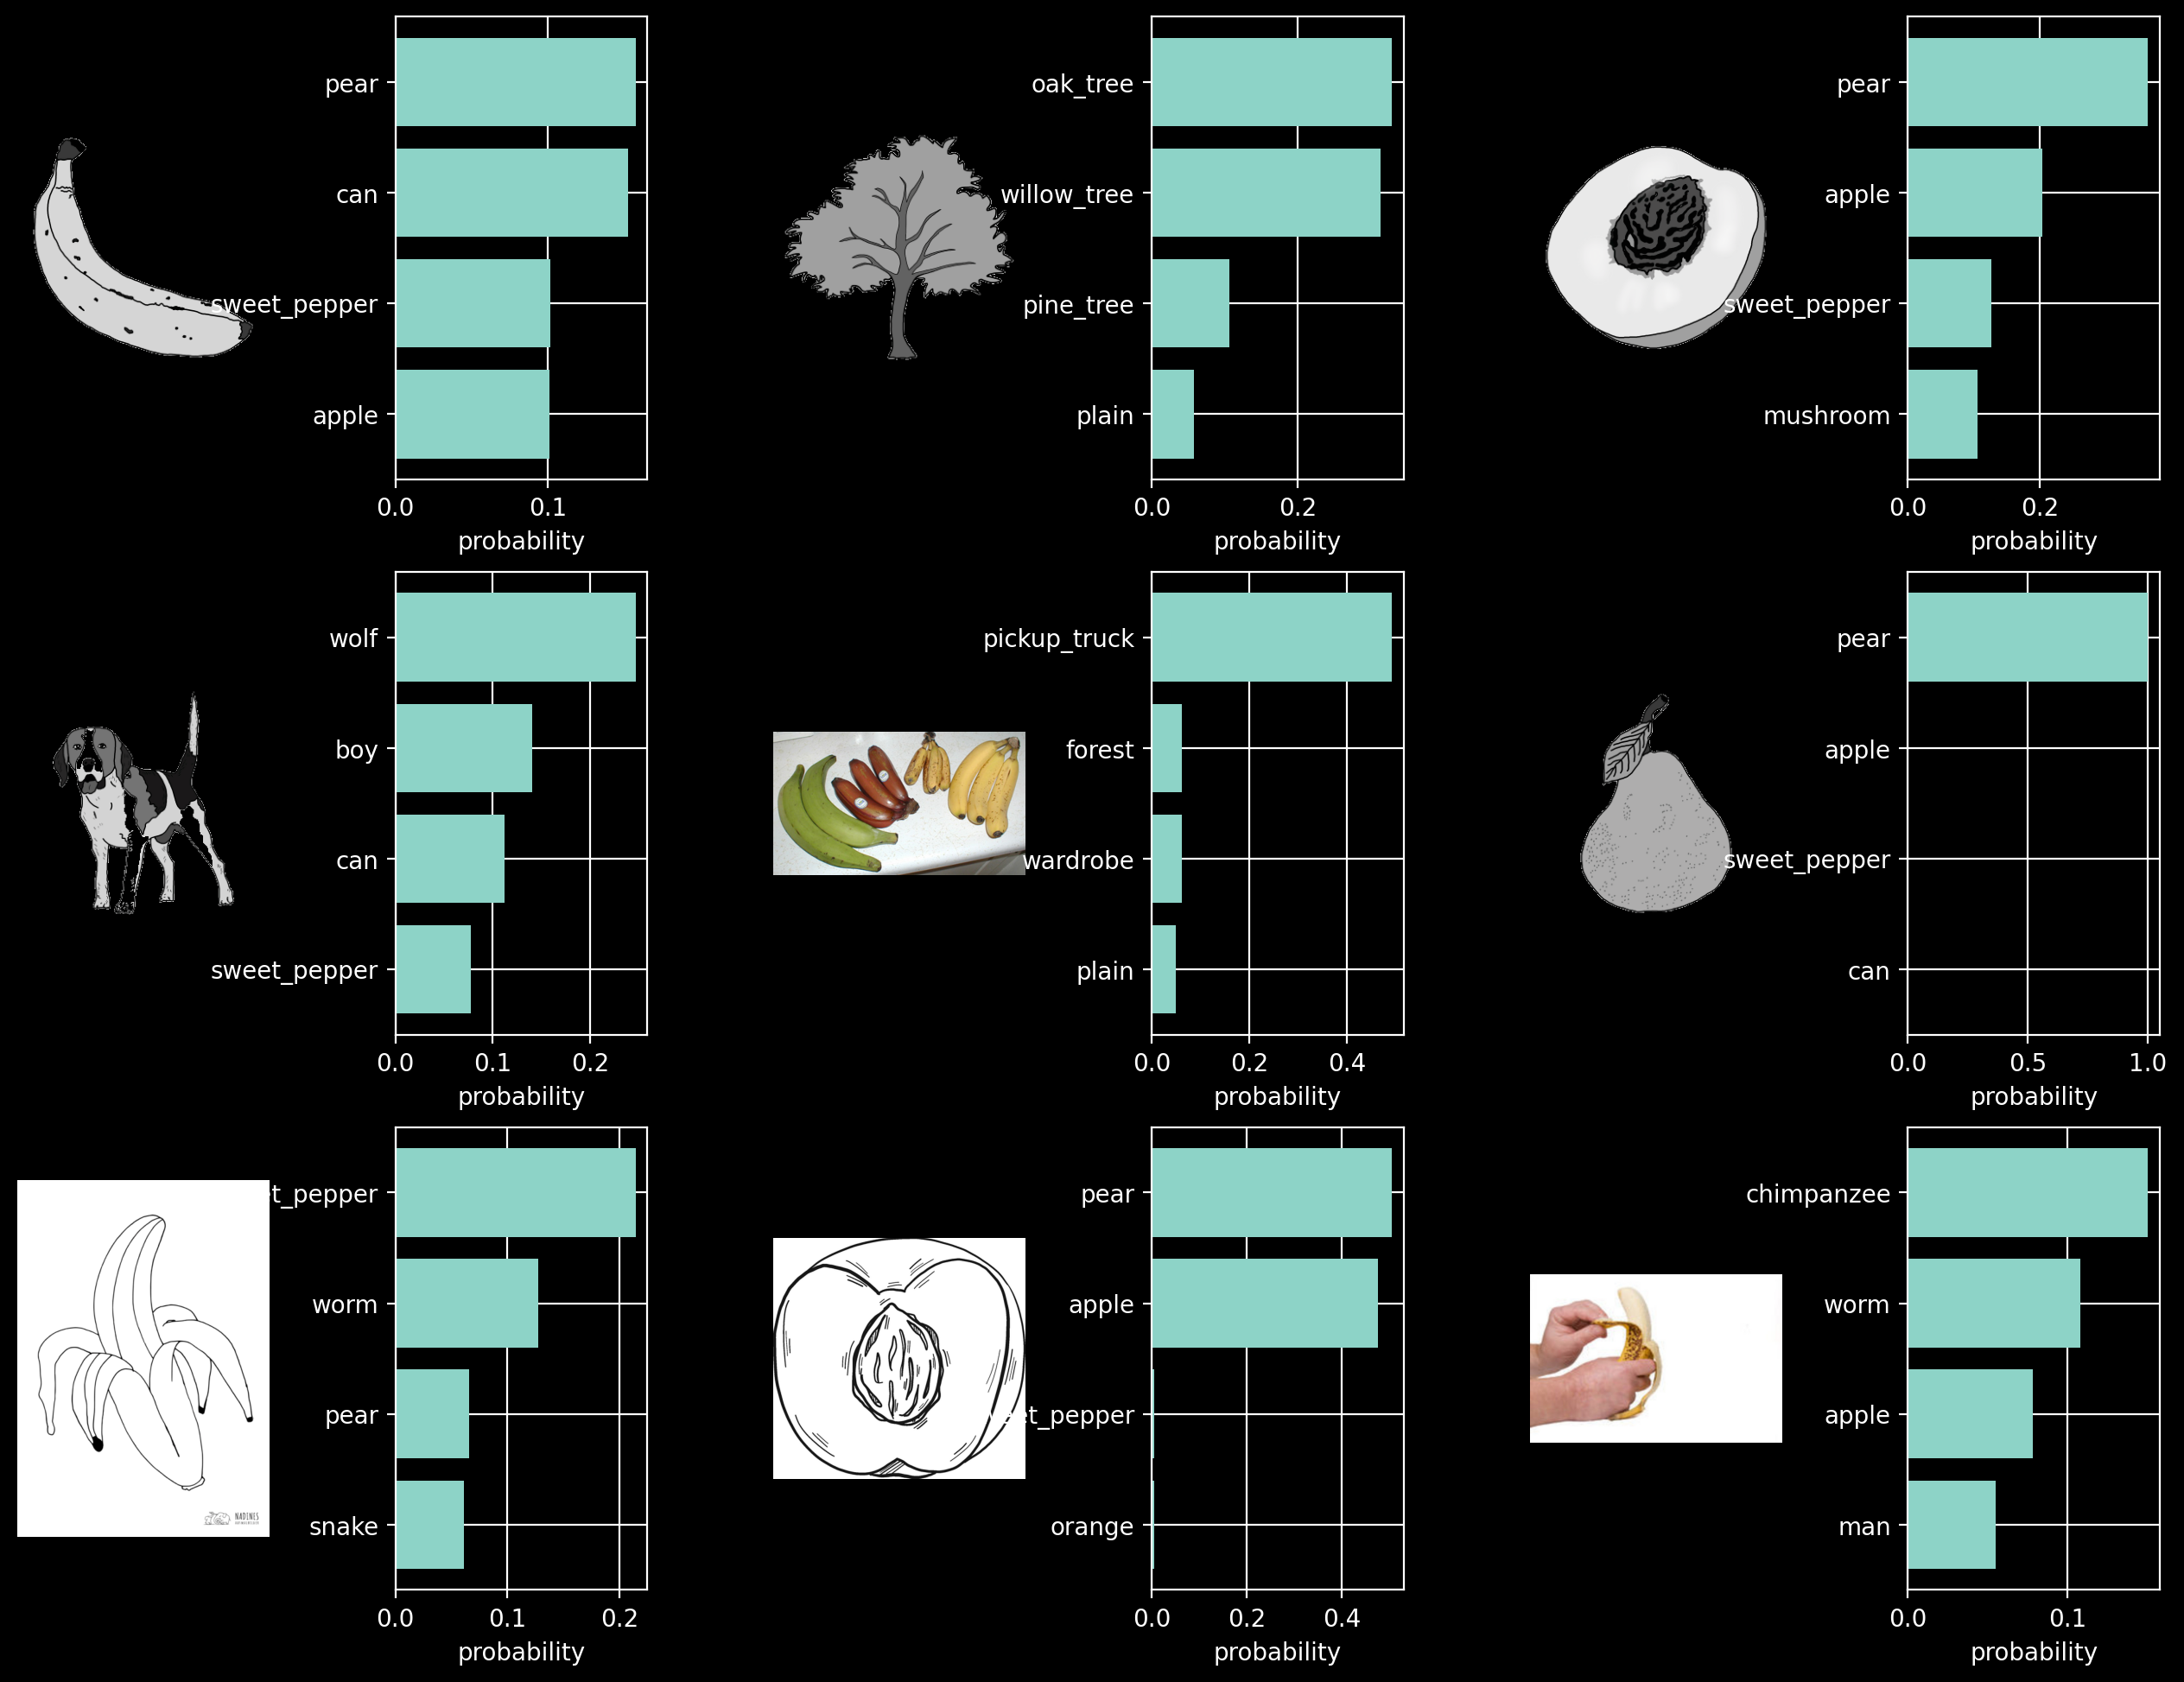

In [33]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(original_images):
    plt.subplot(4, 6, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 6, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [target_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

**TODO:** *Inspect the differences in the predictions depending on the textual prompt. Also note the dependence on the target classes that we gave during inference (100 CIFAR classes).*

### The following code for zero-shot classification is an adaptation of 
https://colab.research.google.com/drive/14m4_zvpW-ZFuXp-KuvNryEKBZoe7NqGA#scrollTo=Mi69N2phL0kU&line=1&uniqifier=1

---
### Interim Summary (Zero-Shot Classification): Ingredients
1. Data setup: (i) get image--class pairs, where the classes are the reference data, and load the data (ii) define a corresponding target vocabulary of classes, (iii) define one or more textual prompts, that you need to instantiate with all target classes.
2. Encode the images and textual prompts into feature representations using CLIP
3. Inference: Predict the class for each input instance, using zero-shot classification
4. (Not shown above:) Compute the accuracy
5. (Visualise results)

**1. Data setup** <br/>
1. (i) Loading the data: see above

In [34]:
# image: label (frame/object class)
coloured_objects_data = {
    # Q: How to adapt to multi-label prediction?
    "PICTURE_69.png": "banana",
    "PICTURE_693.png": "tree",
    "PICTURE_697.png": "peach",
    "PICTURE_707.png": "dog",
    "banana_wikipedia.jpg": "banana",
    "PICTURE_42.png": "pear",
    "banana_gratismalvorlagen.png": "banana",
    "peach_supercoloring.png": "peach",
    "peeling_91.jpg": "peeling"
}

In [35]:
target_classes = ["tree", "cat", "woman", "pizza", 
                    "banana", "pear", "barbecue", "flower", 
                    "puppy", "dog", "peach", 
                    "apple", "eating", "peeling"]
target_class2idx = {c:idx for (idx,c) in enumerate(target_classes)}

In [36]:
# Needed for computing the accuracy (see below):
target_class2idx

{'tree': 0,
 'cat': 1,
 'woman': 2,
 'pizza': 3,
 'banana': 4,
 'pear': 5,
 'barbecue': 6,
 'flower': 7,
 'puppy': 8,
 'dog': 9,
 'peach': 10,
 'apple': 11,
 'eating': 12,
 'peeling': 13}

In [37]:
# For zero-shot classification
# We want to use more than one prompt, and get a 
# mean prompt embedding for them: 
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.']

In [38]:
# Example with first class in our target classes
classname = target_classes[0]
print([template.format(classname) for template in imagenet_templates])

['a bad photo of a tree.', 'a photo of many tree.', 'a sculpture of a tree.', 'a photo of the hard to see tree.', 'a low resolution photo of the tree.', 'a rendering of a tree.']


**2. Encoding the textual prompt(s), and the images** <br/>
To encode the textual prompts, you can use the method `zeroshot_classifier` which provides above functionality, additionally using different prompts:

In [39]:
from tqdm.notebook import tqdm
# encoding textual prompts
def zeroshot_classifier(classnames, templates, model):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            #print(texts)
            texts = clip.tokenize(texts) #tokenize
            if torch.cuda.is_available():
                texts = texts.cuda()
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            # compute the mean embedding for each class
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
            
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1)
        if torch.cuda.is_available():
            zeroshot_weights = zeroshot_weights.cuda()
    return zeroshot_weights

In [40]:
# Example:
# If we wanted to only use the single template prompt from above:
#text_features = zeroshot_classifier(target_classes, imagenet_templates[:1], model)
# We use multiple prompts as explained above 
# and compute a mean textual class representation for each of them
zeroshot_text_feats = zeroshot_classifier(target_classes, imagenet_templates, model)

  0%|          | 0/14 [00:00<?, ?it/s]

**2.2 and 3.: Encode the images and predict the classes**<br/>
*You may use a single function, `predict`, for that:*

In [47]:
def predict(images, text_features, classnames, model, topk=5):
    num_classes = len(classnames)
    image_input = torch.tensor(np.stack(images))
    if torch.cuda.is_available():
        image_input = image_input.cuda()        
    with torch.no_grad():
        image_features= model.encode_image(image_input).float()
        image_features /= image_features.norm(dim=-1, keepdim=True).float()

    text_probs = (100.0 * image_features @ text_features.float()).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(min(topk,num_classes), dim=-1)
    return top_probs, top_labels

In [48]:
# Example:
# If we wanted to only use the single template prompt from above:
#top_probs, top_labels = predict(images, zeroshot_text_feats, target_classes, model)
top_probs, top_labels = predict(images, zeroshot_text_feats, target_classes, model)
top_labels

tensor([[ 4, 13,  5, 11, 10],
        [ 0,  7,  2, 11, 10],
        [10,  5, 11, 13,  3],
        [ 9,  8, 10,  2, 12],
        [ 4, 13, 12, 11,  6],
        [ 5, 10, 11, 13,  4],
        [ 4, 13, 11,  5, 12],
        [10, 11,  5, 13,  4],
        [ 4, 13, 11, 12, 10]])

In [54]:
top_probs

tensor([[9.6590e-01, 3.1800e-02, 1.2242e-03, 8.3400e-04, 1.1808e-04],
        [9.7436e-01, 4.5052e-03, 4.3343e-03, 3.8780e-03, 3.2472e-03],
        [5.5842e-01, 2.1741e-01, 2.0201e-01, 1.6234e-02, 1.9575e-03],
        [9.1005e-01, 8.5403e-02, 1.1214e-03, 9.5584e-04, 8.3338e-04],
        [6.1888e-01, 3.7904e-01, 1.4315e-03, 3.2349e-04, 1.0361e-04],
        [9.9693e-01, 2.6767e-03, 2.6915e-04, 1.0985e-04, 6.9305e-06],
        [9.3131e-01, 6.7846e-02, 3.0485e-04, 2.2423e-04, 1.4393e-04],
        [6.8806e-01, 2.1694e-01, 9.4032e-02, 8.2317e-04, 5.3411e-05],
        [6.5931e-01, 3.3766e-01, 1.3324e-03, 6.7279e-04, 3.3551e-04]])

**4. Compute the accuracy**

In [49]:
# Note that the function expects the reference target classes encoded 
# as a vector of class indices (see below)
def accuracy(pred_scores, preds, targets, topk=(1,5)):
    correct = top_labels.eq(targets.view(targets.size(0), -1).expand_as(top_labels))
    acc1, acc5 = [float(correct[:,:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
    return acc1, acc5

In [50]:
coloured_objects_data

{'PICTURE_69.png': 'banana',
 'PICTURE_693.png': 'tree',
 'PICTURE_697.png': 'peach',
 'PICTURE_707.png': 'dog',
 'banana_wikipedia.jpg': 'banana',
 'PICTURE_42.png': 'pear',
 'banana_gratismalvorlagen.png': 'banana',
 'peach_supercoloring.png': 'peach',
 'peeling_91.jpg': 'peeling'}

In [51]:
# Example:
# First put the targets in the reference data into 
# a vector of target class indices
list_target_inds = [target_class2idx[coloured_objects_data[imgname]] for imgname in imgnames]
target_inds = torch.tensor(list_target_inds).cpu()
    
accuracy(top_probs, top_labels, target_inds, topk=(1,3))

(8.0, 9.0)

**5. (Plot the predictions)**

In [52]:
def plot_predictions(original_images, imagenames, 
                     pred_probs, pred_labels, target_labels):
    plt.figure(figsize=(16, 16))

    for i, image in enumerate(original_images):
        plt.subplot(4, 6, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.subplot(4, 6, 2 * i + 2)
        y = np.arange(pred_probs.shape[-1])
        plt.grid()

        plt.title(imagenames[i])
        plt.barh(y, pred_probs[i])

        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
      
        plt.yticks(y, [target_labels[index] for index in pred_labels[i].numpy()])
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

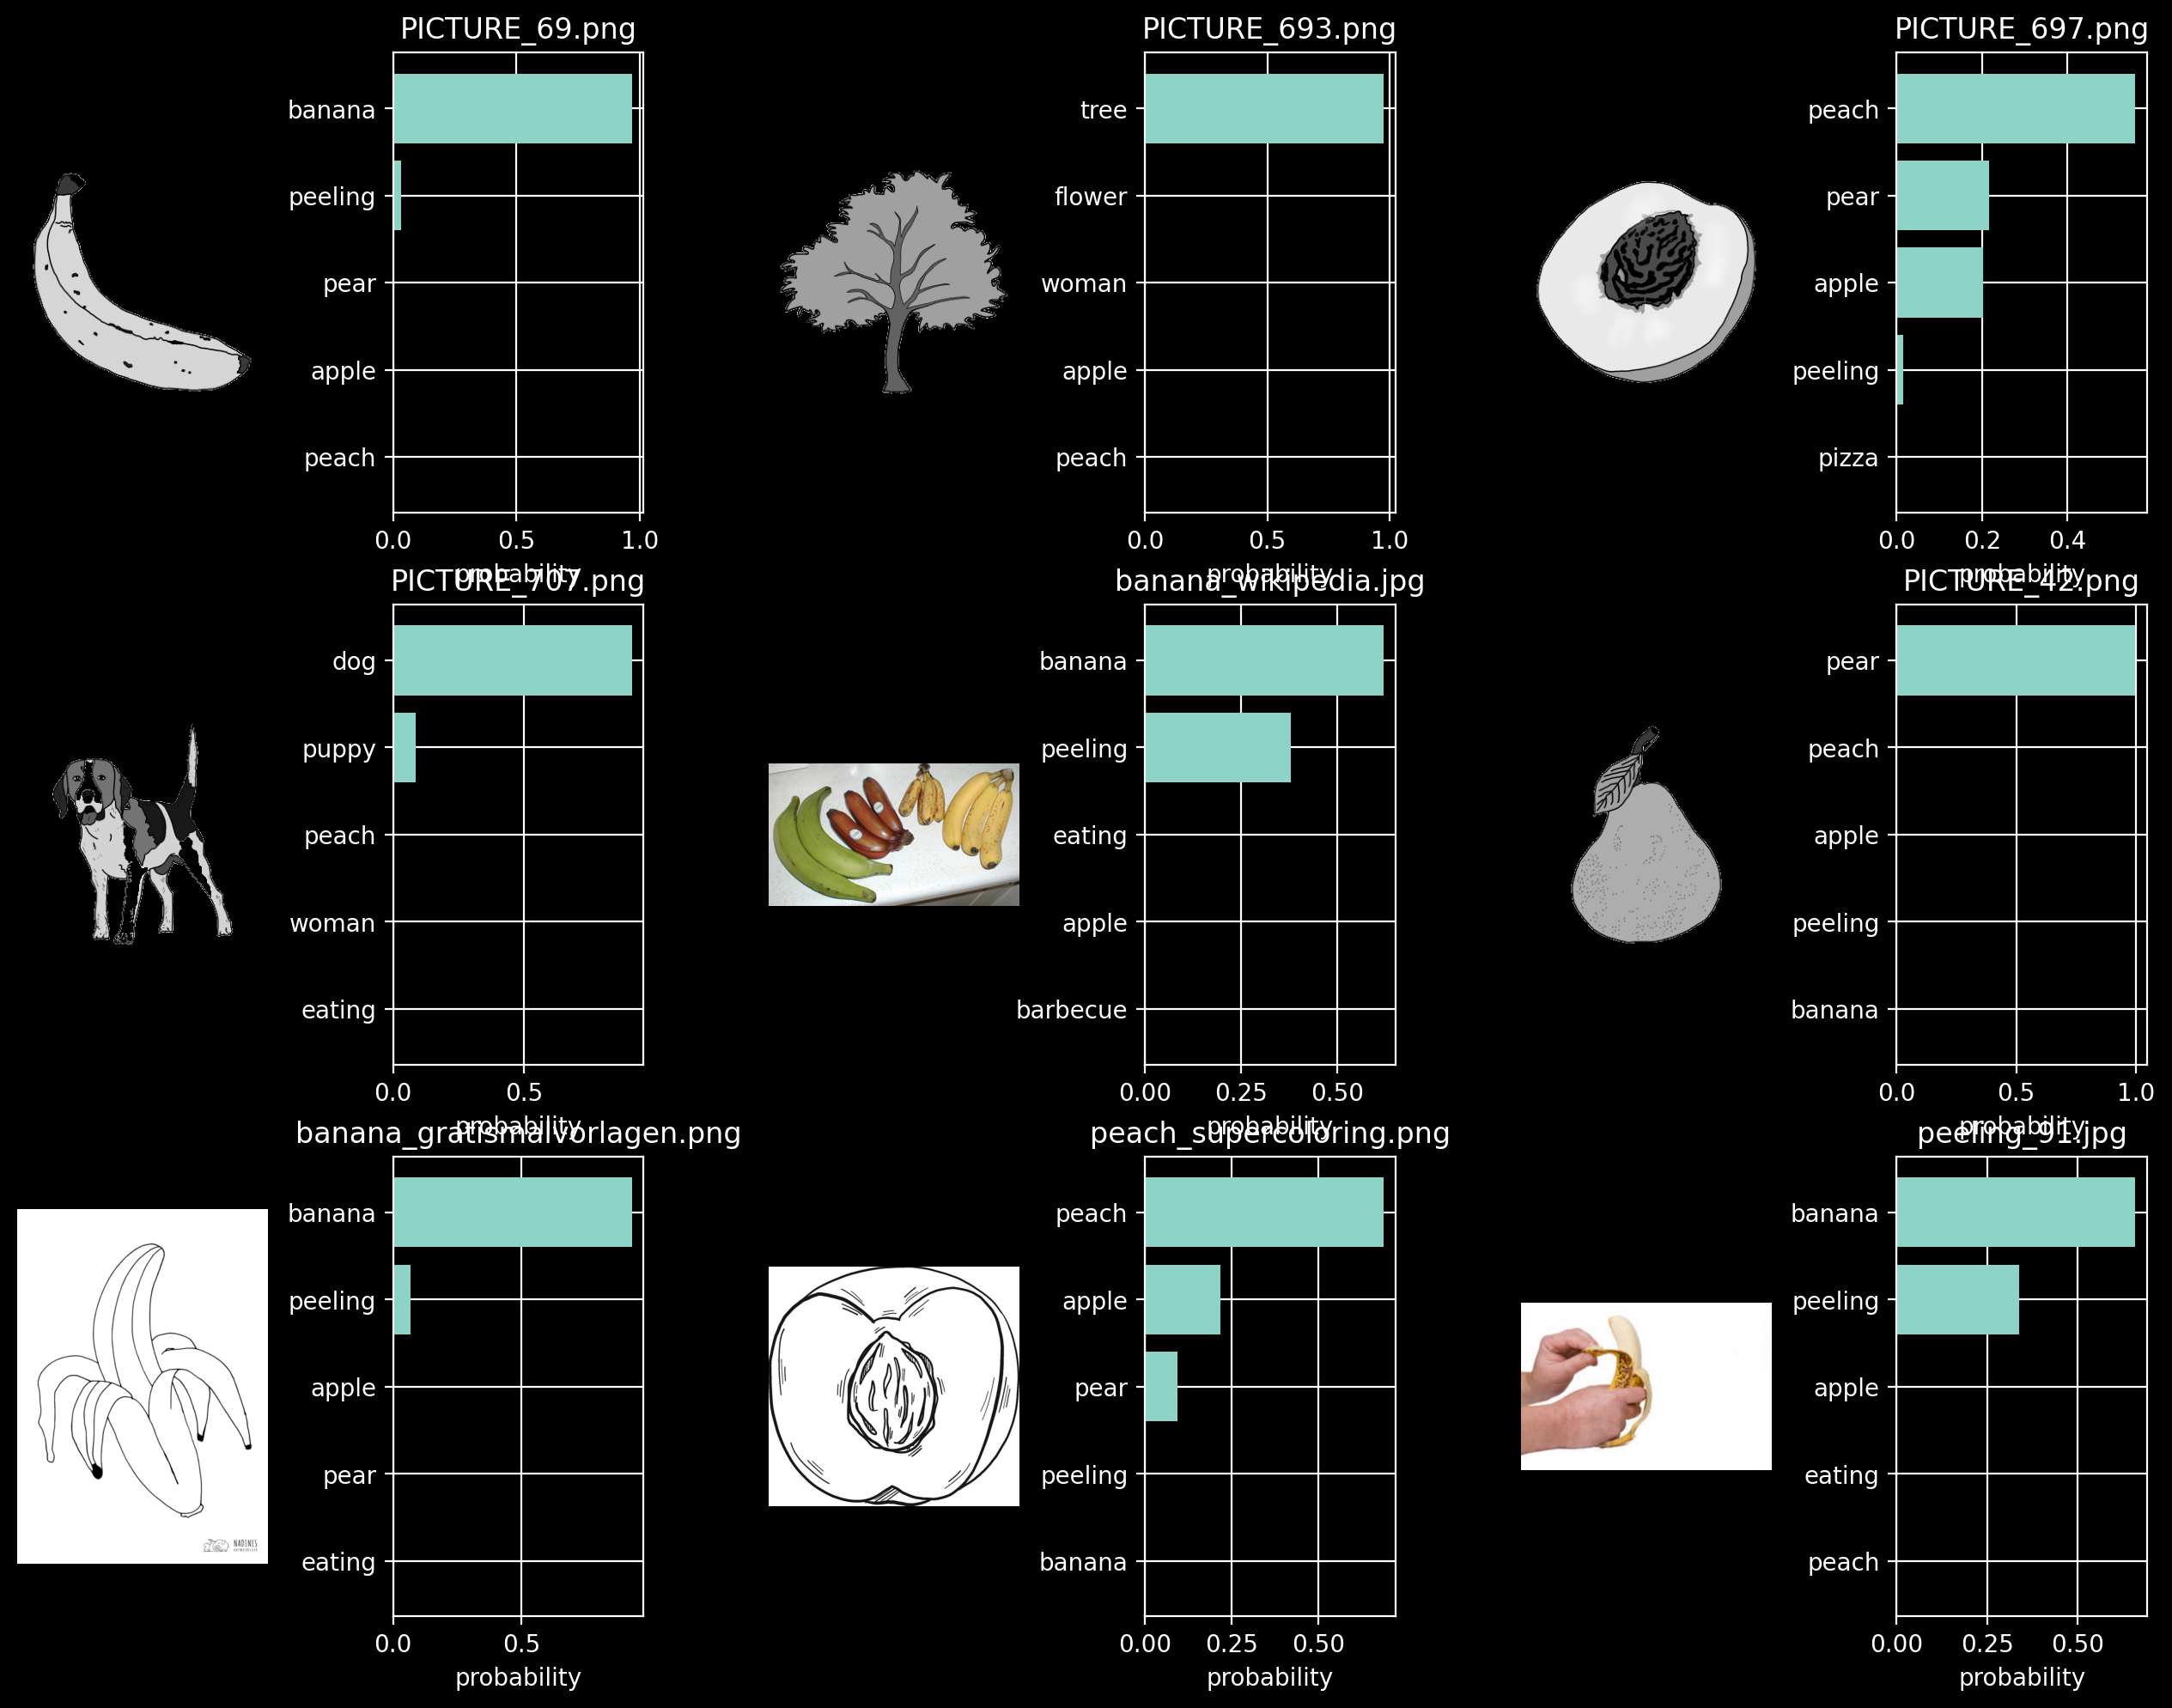

In [53]:
# Example
plot_predictions(original_images, imgnames,
                 top_probs, top_labels, target_classes)    

### Zero-shot Classification: Putting it all together

In [55]:
original_images = []
images = []
imgnames = []
list_target_inds = [] # we store the target labels' index of their position in the class vector (our_classes)
kPreds = 5
class2idx = {c:idx for (idx,c) in enumerate(target_classes)}


with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for (item_id, target) in coloured_objects_data.items():
        if item_id.endswith(".png") or item_id.endswith(".jpg"):
            image = Image.open(os.path.join(image_dir, item_id)).convert("RGB")
            original_images.append(image)
            imgnames.append(item_id)
            list_target_inds.append(class2idx[target])
            
            # Preprocess the image with CLIP's preprocessor
            images.append(preprocess(image))
                
    target_inds = torch.tensor(list_target_inds).cpu()
    # encode textual class representations
    zeroshot_text_feats = zeroshot_classifier(target_classes, imagenet_templates, model)
    # encode image representations and predict the class of each item 
    top_probs, top_labels = predict(images, zeroshot_text_feats, 
                                    target_classes, model, topk=kPreds)

    # measure accuracy
    acc1, acc5 = accuracy(top_probs, top_labels, target_inds, topk=(1,kPreds))
    top1 += acc1
    top5 += acc5
    n += len(images)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100 

print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/14 [00:00<?, ?it/s]

Top-1 accuracy: 88.89
Top-5 accuracy: 100.00


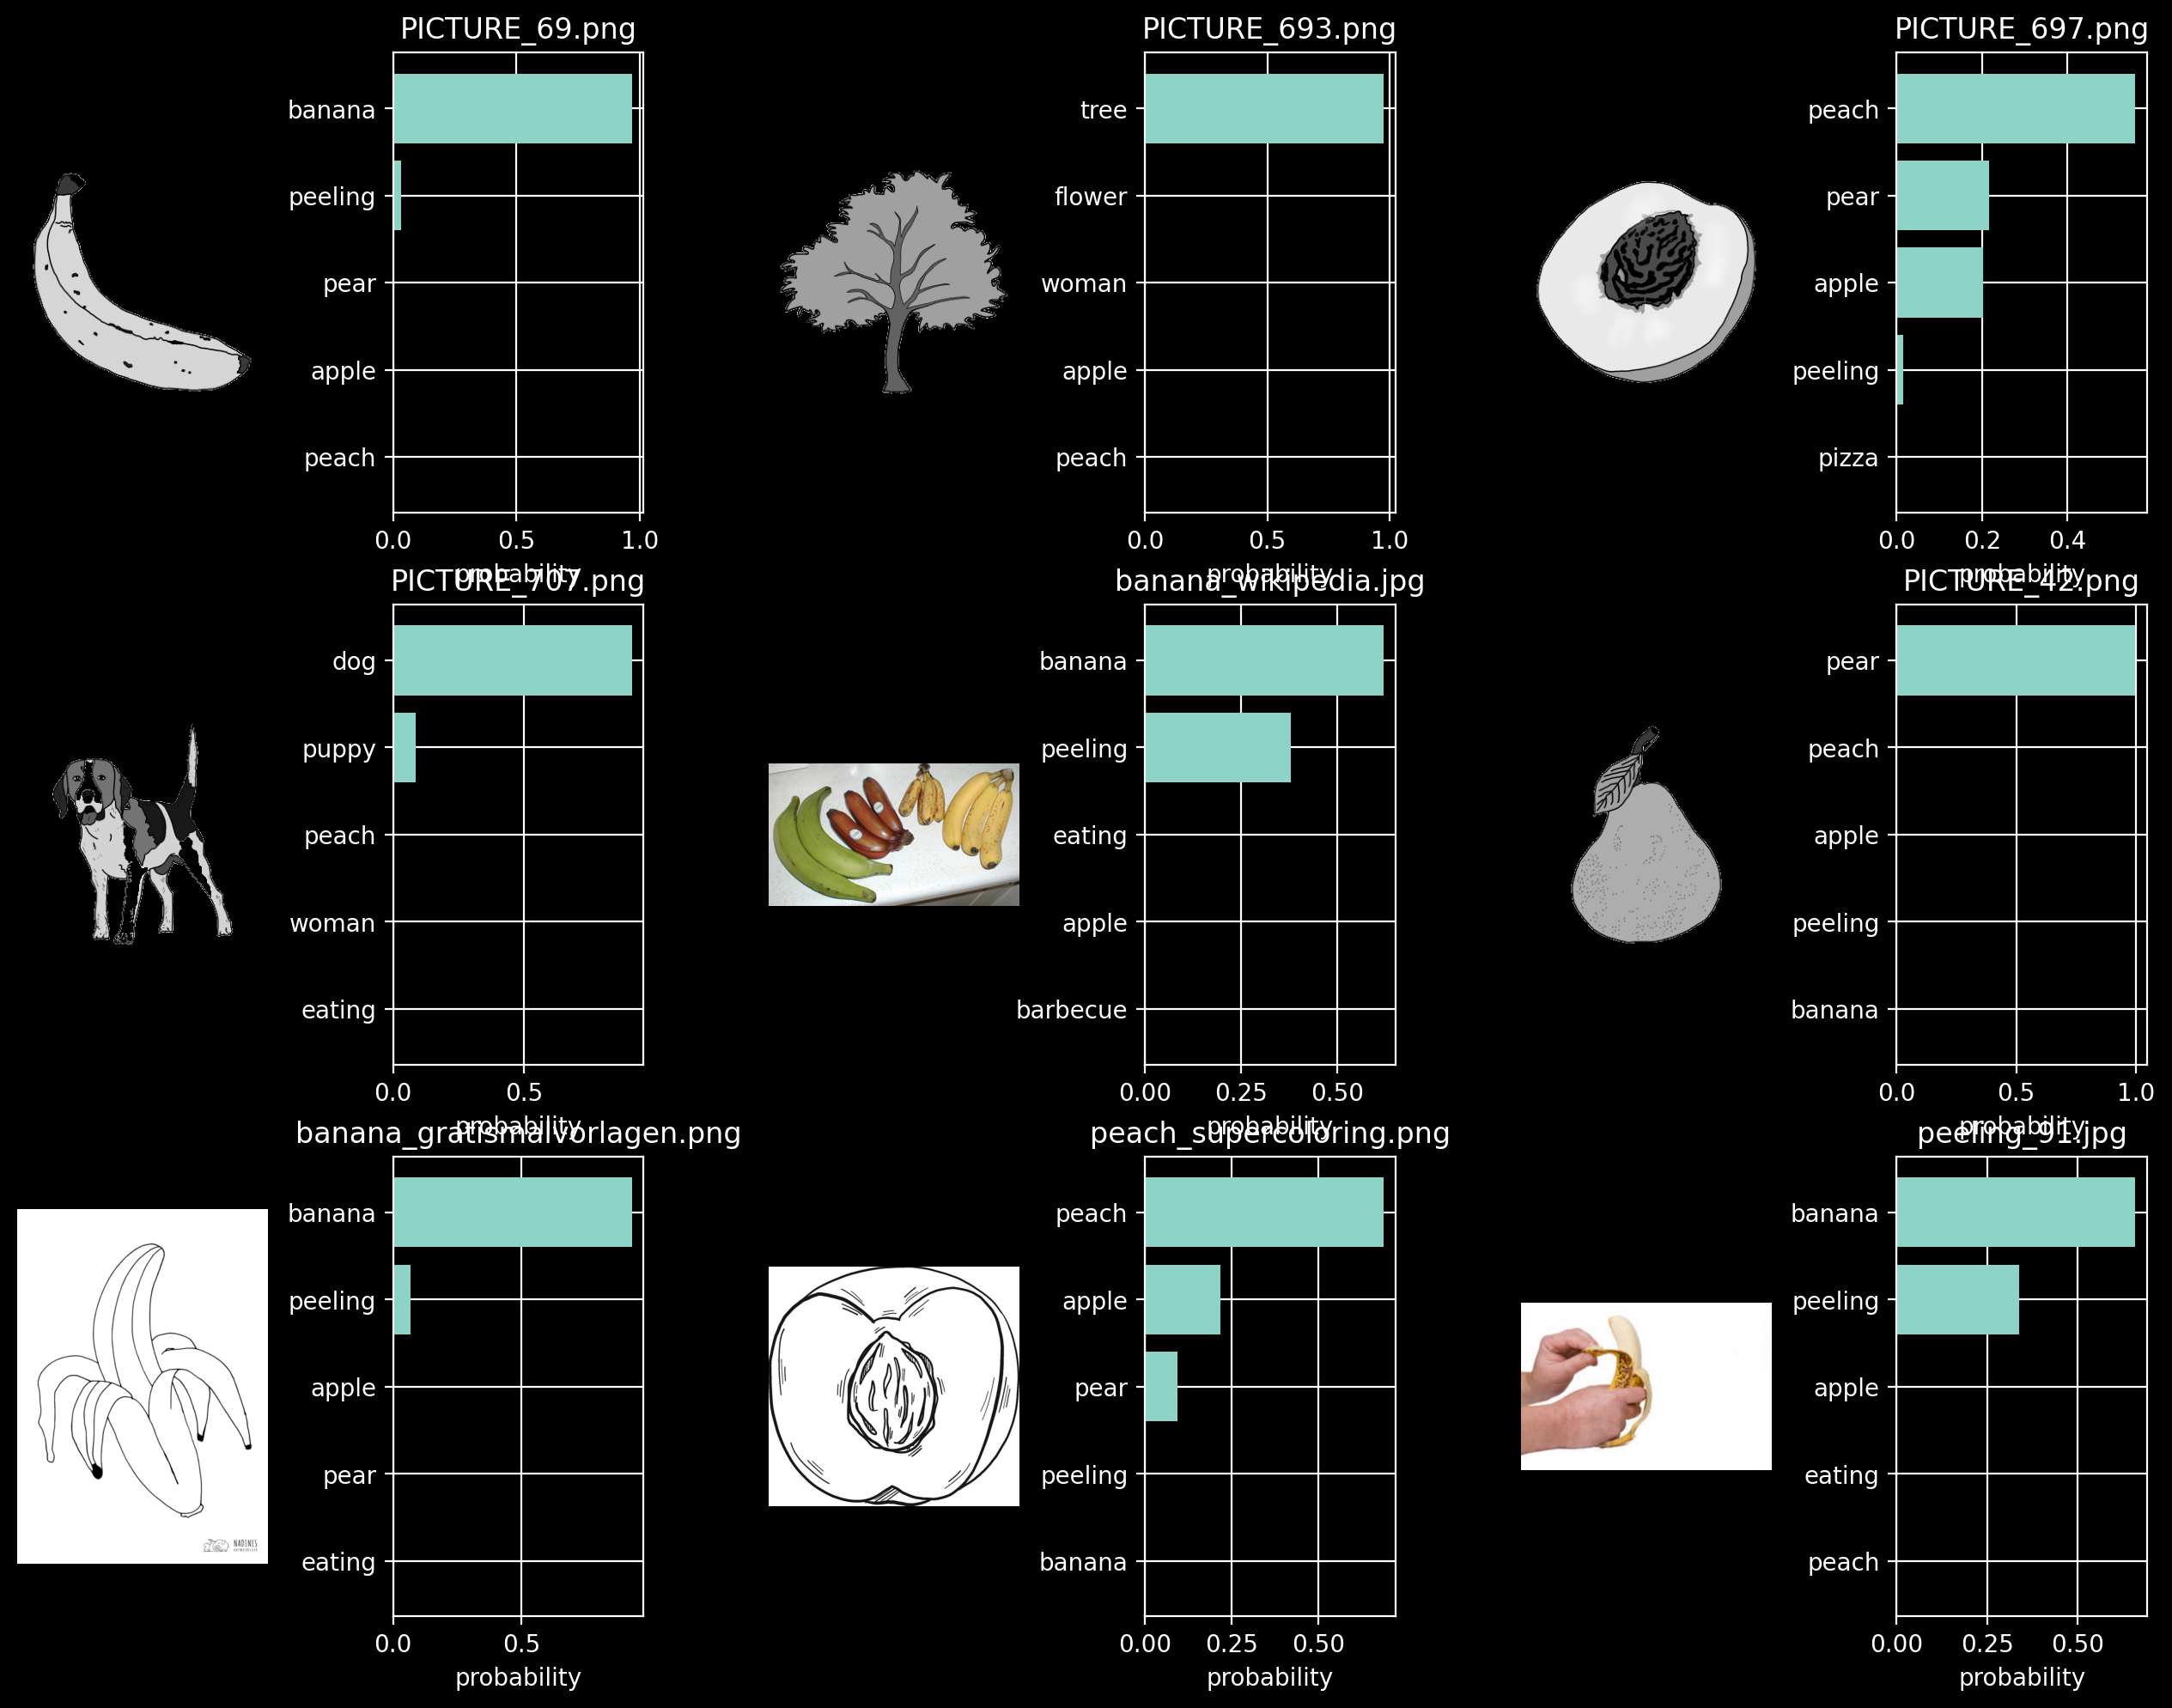

In [56]:
plot_predictions(original_images, imgnames,
                 top_probs, top_labels, target_classes)    